In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import torchvision
from torchvision import transforms
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [68]:
def load_and_process_data():
    # Load the merged dataframe
    merged_df = pd.read_csv('/Users/omama/Documents/Portfolio/respiratory_classification/data/processed_respiratory_data.csv')
    
    # Create a dictionary mapping filenames to diagnosis labels
    label_dict = dict(zip(merged_df['filename'].str.replace('.wav', '.png'), merged_df['Diagnosis']))
    
    # Sort the unique labels and map them to numerical values for consistency
    sorted_labels = sorted(set(label_dict.values()))
    label_mapping = {label: idx  for idx, label in enumerate(sorted_labels)}
    
    # Print the label mapping
    print("Label Mapping:")
    for label, num in label_mapping.items():
        print(f"{label} -> {num}")
    
    # Convert each label in label_dict to its numerical value
    numerical_labels = {k: label_mapping[v] for k, v in label_dict.items()}
    
    # Split the data into filenames and corresponding numerical labels
    filenames = list(numerical_labels.keys())
    labels = list(numerical_labels.values())
    
    return filenames, labels

In [69]:
class SpectrogramDataset(Dataset):
    def __init__(self, file_list, label_list, root_dir, transform=None):
        self.file_list = file_list
        self.label_list = label_list
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [70]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [71]:

# Ensure the current working directory is correct
print("Current Working Directory:", os.getcwd())
# Change the working directory
desired_cwd = '/Users/omama/Documents/Portfolio/respiratory_classification/data'
os.chdir(desired_cwd)
print("New Current Working Directory:", os.getcwd())
root_dir = desired_cwd

filenames, labels = load_and_process_data()


# Split the data into training, validation, and test sets
train_files, test_files, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.25, random_state=42)

# Create datasets
train_dataset = SpectrogramDataset(train_files, train_labels, root_dir=root_dir, transform=transform)
val_dataset = SpectrogramDataset(val_files, val_labels, root_dir=root_dir, transform=transform)
test_dataset = SpectrogramDataset(test_files, test_labels, root_dir=root_dir, transform=transform)

# print ("Number of training examples: " + str(train_dataset.length))
# print ("Number of validation examples: " + str(val_dataset.length))
# print ("Number of testing examples: " + str(test_dataset.length))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Current Working Directory: /Users/omama/Documents/Portfolio/respiratory_classification/data
New Current Working Directory: /Users/omama/Documents/Portfolio/respiratory_classification/data
Label Mapping:
Asthma -> 0
Bronchiectasis -> 1
Bronchiolitis -> 2
COPD -> 3
Healthy -> 4
LRTI -> 5
Pneumonia -> 6
URTI -> 7


In [72]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_dataloader(dataloader, classes, num_images=20):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]

    # Create a grid from the batch of images
    img_grid = torchvision.utils.make_grid(images)

    # Show images
    imshow(img_grid)

    # Print labels
    print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(num_images)))

Training Data:


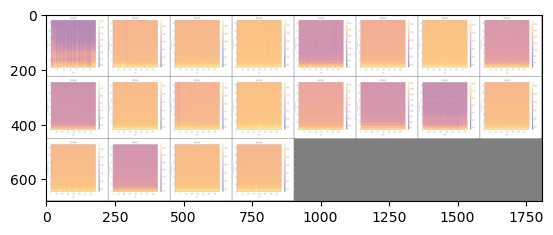

Labels: COPD COPD COPD COPD COPD COPD COPD COPD Bronchiectasis COPD COPD COPD COPD Healthy COPD COPD COPD Pneumonia COPD COPD
Validation Data:


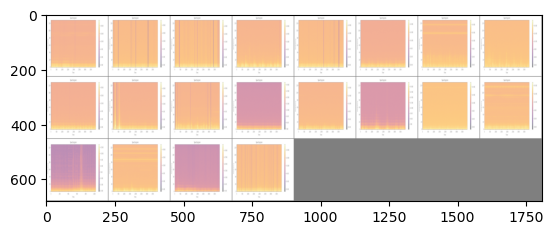

Labels: COPD COPD COPD COPD COPD COPD COPD COPD COPD COPD COPD Pneumonia COPD URTI COPD COPD COPD COPD Healthy COPD
Test Data:


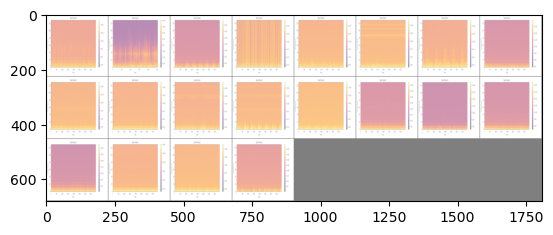

Labels: COPD COPD Pneumonia COPD COPD COPD COPD COPD COPD COPD COPD COPD COPD URTI URTI COPD Pneumonia COPD COPD COPD


In [73]:
# Define your class labels (ensure these match the order in label_mapping)
classes = [
    'Asthma', 'Bronchiectasis', 'Bronchiolitis', 
    'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI'
]

# Visualize training data
print("Training Data:")
visualize_dataloader(train_loader, classes)

# Visualize validation data
print("Validation Data:")
visualize_dataloader(val_loader, classes)

# Visualize test data
print("Test Data:")
visualize_dataloader(test_loader, classes)


In [74]:
merged_df = pd.read_csv('/Users/omama/Documents/Portfolio/respiratory_classification/data/processed_respiratory_data.csv')
print(merged_df['Diagnosis'].value_counts())

Diagnosis
COPD              5746
Healthy            322
Pneumonia          285
URTI               243
Bronchiolitis      160
Bronchiectasis     104
LRTI                32
Asthma               6
Name: count, dtype: int64


In [75]:
from collections import Counter
# Function to count labels in a DataLoader
def count_labels(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.numpy())
    return label_counts

# Count labels in each DataLoader
train_label_counts = count_labels(train_loader)
val_label_counts = count_labels(val_loader)
test_label_counts = count_labels(test_loader)

# Print label counts
print("Training Data Label Counts:", train_label_counts)
print("Validation Data Label Counts:", val_label_counts)
print("Test Data Label Counts:", test_label_counts)

Training Data Label Counts: Counter({3: 478, 4: 19, 6: 19, 7: 13, 1: 12, 2: 8, 5: 2, 0: 1})
Validation Data Label Counts: Counter({3: 156, 4: 10, 6: 9, 2: 4, 7: 3, 1: 2})
Test Data Label Counts: Counter({3: 159, 6: 9, 7: 7, 4: 6, 1: 2, 2: 1})


In [77]:
import torch

# Calculate the frequency of each class in the training dataset
class_counts = np.array([train_label_counts.get(i, 0) for i in range(num_classes)])

# Avoid division by zero by setting zero counts to a very small number
class_counts = np.where(class_counts == 0, 1e-6, class_counts)

# Calculate class weights
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize weights
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(f"Class Counts: {class_counts}")
print(f"Class Weights: {class_weights}")

Class Counts: [  1.  12.   8. 478.  19.   2.  19.  13.]
Class Weights: tensor([0.5284, 0.0440, 0.0660, 0.0011, 0.0278, 0.2642, 0.0278, 0.0406])


In [78]:
import torch.nn as nn
import torch.nn.functional as F


class RespiratoryDiseaseCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(RespiratoryDiseaseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [79]:
import torch.optim as optim

# Initialize the model
num_classes = len(classes)
model = RespiratoryDiseaseCNN(num_classes=num_classes)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training and validation loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    

Epoch 1/25, Loss: 2.5133, Accuracy: 0.5199
Epoch 2/25, Loss: 2.0431, Accuracy: 0.6051
Epoch 3/25, Loss: 2.1295, Accuracy: 0.5670
Epoch 4/25, Loss: 2.0116, Accuracy: 0.8605
Epoch 5/25, Loss: 2.1761, Accuracy: 0.4819
Epoch 6/25, Loss: 2.1526, Accuracy: 0.2572
Epoch 7/25, Loss: 2.0515, Accuracy: 0.7101
Epoch 8/25, Loss: 2.1403, Accuracy: 0.0779
Epoch 9/25, Loss: 2.0179, Accuracy: 0.8460
Epoch 10/25, Loss: 1.9455, Accuracy: 0.7899
Epoch 11/25, Loss: 2.0758, Accuracy: 0.7627
Epoch 12/25, Loss: 2.0465, Accuracy: 0.2464
Epoch 13/25, Loss: 2.0779, Accuracy: 0.1178
Epoch 14/25, Loss: 2.0519, Accuracy: 0.3207
Epoch 15/25, Loss: 2.0720, Accuracy: 0.4203
Epoch 16/25, Loss: 2.0676, Accuracy: 0.4620
Epoch 17/25, Loss: 2.0654, Accuracy: 0.4837
Epoch 18/25, Loss: 2.0266, Accuracy: 0.5399
Epoch 19/25, Loss: 2.0620, Accuracy: 0.4620
Epoch 20/25, Loss: 2.0397, Accuracy: 0.5000
Epoch 21/25, Loss: 2.0516, Accuracy: 0.4221
Epoch 22/25, Loss: 2.0337, Accuracy: 0.4728
Epoch 23/25, Loss: 2.0427, Accuracy: 0.76

In [80]:
# Validation
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0
    
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
    
val_epoch_loss = val_loss / len(val_loader.dataset)
val_epoch_acc = val_correct / val_total
print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')


Validation Loss: 1.9312, Validation Accuracy: 0.8478


In [81]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_epoch_loss = test_loss / len(test_loader.dataset)
test_epoch_acc = test_correct / test_total
print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.4f}')

Test Loss: 1.8890, Test Accuracy: 0.8641
